In [73]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
import eli5
import sklearn

from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, log_loss

In [2]:
train = pd.read_csv('data/train_clean.csv', index_col = 0)
X_test = pd.read_csv('data/test_clean.csv', index_col = 0)
submission = pd.read_csv('data/sample_submission.csv')

feature = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'child_num', 'family_size', 'age', 'work_year', 'use_month', 'income_total']
target = ['credit']

X_train = train[feature]
y_train = train[target]

In [3]:
X_train, X_val, y_train, y_val = train_test_split(train[feature],train[target], test_size = 0.2, train_size = 0.8)

In [56]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(n_estimators=200, 
                          random_state=2,
                          n_jobs=-1,
                          max_depth=7,
                          learning_rate=0.2))], verbose = 1)

pipe.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=  12.3s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('targetencoder',
                                  TargetEncoder(cols=['income_type', 'edu_type',
                                                      'family_type',
                                                      'house_type',
                                                      'occyp_type'])),
                                 ('simpleimputer', SimpleImputer())])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=2, reg_alpha=0, ...))],
         verbose=1)

In [59]:
X_train_transformed = pipe.named_steps['preprocessing'].transform(X_train)
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

pipe.named_steps['xgb'].fit(X_train_transformed, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.00979	validation_1-mlogloss:1.01643
[1]	validation_0-mlogloss:0.94644	validation_1-mlogloss:0.95891
[2]	validation_0-mlogloss:0.90054	validation_1-mlogloss:0.91829
[3]	validation_0-mlogloss:0.86631	validation_1-mlogloss:0.88898
[4]	validation_0-mlogloss:0.84139	validation_1-mlogloss:0.86771
[5]	validation_0-mlogloss:0.82172	validation_1-mlogloss:0.85216
[6]	validation_0-mlogloss:0.80653	validation_1-mlogloss:0.84069
[7]	validation_0-mlogloss:0.79526	validation_1-mlogloss:0.83232
[8]	validation_0-mlogloss:0.78587	validation_1-mlogloss:0.82584
[9]	validation_0-mlogloss:0.77802	validation_1-mlogloss:0.82167
[10]	validation_0-mlogloss:0.77074	validation_1-mlogloss:0.81777
[11]	validation_0-mlogloss:0.76487	validation_1-mlogloss:0.81457
[12]	validation_0-mlogloss:0.76008	validation_1-mlogloss:0.81199
[13]	validation_0-mlogloss:0.75557	validation_1-mlogloss:0.80988
[14]	validation_0-mlogloss:0.75139	validation_1-mlogloss:0.80834
[15]	validation_0-mlogloss:0.74797	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=2, reg_alpha=0, ...)

In [75]:
%%time
params = {'xgb__max_depth':[5,6,7,8,9,10,15], 
          'xgb__min_child_weight':[5,7,10,15], 
          'xgb__colsample_bytree':[0.5,0.75],
          'xgb__learning_rate' : uniform(0,1)}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
randcv = RandomizedSearchCV(pipe,
                            param_distributions=params,
                            n_iter = 10,
                            cv=5,
                            scoring = 'neg_log_loss',
                            verbose = 10,
                            random_state = 42)

# 파라미터 튜닝 시작
randcv.fit(X_train, y_train)

#튜닝된 파라미터 출력
print(randcv.best_params_)

# 1차적으로 튜닝된 파라미터를 가지고 객체 생성
# xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 학습
# xgb_model.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_val, y_val)])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START xgb__colsample_bytree=0.5, xgb__learning_rate=0.7965429868602328, xgb__max_depth=15, xgb__min_child_weight=10
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.7s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=  12.8s
[CV 1/5; 1/10] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.7965429868602328, xgb__max_depth=15, xgb__min_child_weight=10;, score=-1.090 total time=  13.6s
[CV 2/5; 1/10] START xgb__colsample_bytree=0.5, xgb__learning_rate=0.7965429868602328, xgb__max_depth=15, xgb__min_child_weight=10
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=  11.1s
[CV 2/5; 1/10] END xgb__colsample_bytree=0.5, xgb__learning_rate=0.7965429868602328, xgb__max_depth=15, xgb__min_child_weight=10;, score=-1.098 total time=  11.5s
[CV 3/5; 1/10] START xgb__colsample_bytree=0.5, xgb__learning_rate=

In [76]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(n_estimators=200, 
                          random_state=2,
                          n_jobs=-1,
                          max_depth=8,
                          colsample_bytree = 0.5,
                          min_child_weight = 15,
                          learning_rate=0.13949386065204183))], verbose = 1)

pipe.fit(X_train, y_train)

train_score = pipe.score(X_train, y_train)
val_score = pipe.score(X_val, y_val)

y_train_proba = pipe.predict_proba(X_train)
y_val_proba = pipe.predict_proba(X_val)

train_logloss = log_loss(y_train, y_train_proba)
val_logloss = log_loss(y_val, y_val_proba)

train_score, val_score, train_logloss, val_logloss

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=   8.2s


(0.7454287739192063,
 0.6938775510204082,
 0.5976967923143188,
 0.7785682016849879)

111

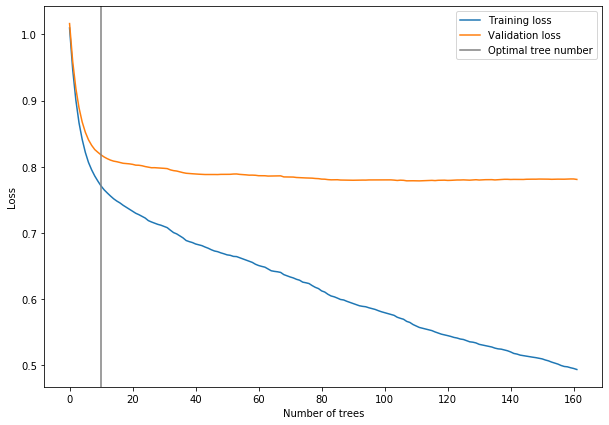

In [66]:
results = pipe.named_steps['xgb'].evals_result()
best_ = pipe.named_steps['xgb'].best_iteration
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(10, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
best_

In [48]:
permuter = PermutationImportance(
    pipe.named_steps['xgb'],
    scoring = 'neg_log_loss',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.2, max_bin=256,
                                              max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=7,
                                              max_leaves=0, min_child_weight=1,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=1,
                                              objective='multi:softprob',
                                              predictor='auto', random_state=2,
                                              reg_alpha=0, ...),
                      random_state=42, scoring='neg_log_loss')

In [53]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names= list(X_val.columns) # list 형식으로 넣어야 합니다
)

Weight,Feature
0.3888 ± 0.0195,use_month
0.0790 ± 0.0025,age
0.0664 ± 0.0047,income_total
0.0472 ± 0.0061,work_year
0.0320 ± 0.0026,occyp_type
0.0131 ± 0.0022,income_type
0.0119 ± 0.0014,family_size
0.0109 ± 0.0024,edu_type
0.0107 ± 0.0017,family_type
0.0097 ± 0.0022,child_num


In [77]:
y_test_proba = pipe.predict_proba(X_test)
submission.iloc[:, 1:] = y_test_proba
submission.to_csv('data/submission2.csv', index = False)